# Asset Pricing in continuous time with the Geometric Brownian Motion (GBM) and the Monte-Carlo simulation

In [1]:
# import modules
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# main variables
# stock_name    :   ticker symbol from yahoo finance
# start_date    :   start date to download prices
# end_date      :   end date to download prices
# pred_end_date :   date until which you want to predict price
# scen_size     :   different possible scenarios
stock_name = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'
scen_size = 10000

In [3]:
# download and prepare data
prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)['Adj Close']
train_set = prices.loc[:end_date]
test_set = prices.loc[end_date:pred_end_date]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

[*********************100%***********************]  1 of 1 completed


In [4]:
# Geometric Brownian Motion (GBM)

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path


# Parameter Assignments
So = train_set[-1]
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end_date,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(pred_end_date,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()


In [5]:
T = n_of_wkdays
N = T / dt

In [11]:
print(T)

44


In [6]:
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [7]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}


In [12]:
drift

array([0.00102875, 0.0020575 , 0.00308625, 0.00411501, 0.00514376,
       0.00617251, 0.00720126, 0.00823001, 0.00925876, 0.01028751,
       0.01131627, 0.01234502, 0.01337377, 0.01440252, 0.01543127,
       0.01646002, 0.01748878, 0.01851753, 0.01954628, 0.02057503,
       0.02160378, 0.02263253, 0.02366128, 0.02469004, 0.02571879,
       0.02674754, 0.02777629, 0.02880504, 0.02983379, 0.03086254,
       0.0318913 , 0.03292005, 0.0339488 , 0.03497755, 0.0360063 ,
       0.03703505, 0.03806381, 0.03909256, 0.04012131, 0.04115006,
       0.04217881, 0.04320756, 0.04423631, 0.04526507])

In [13]:
diffusion

{'1': array([-0.03753772, -0.07175196, -0.07256724, -0.09001562, -0.08082258,
        -0.05338251, -0.05626915, -0.03108864, -0.04655963, -0.01722869,
        -0.0176223 , -0.04917732, -0.07680033, -0.10985435, -0.15325929,
        -0.15836727, -0.15733001, -0.18415459, -0.20033404, -0.21855618,
        -0.15455104, -0.1763733 , -0.16254261, -0.15207511, -0.16358904,
        -0.14212341, -0.13223588, -0.13976579, -0.1040596 , -0.08861812,
        -0.11565412, -0.11673197, -0.1193221 , -0.11257193, -0.11794145,
        -0.11109773, -0.0964322 , -0.09687844, -0.10051335, -0.06315905,
        -0.0907393 , -0.07955943, -0.05198634, -0.06086202]),
 '2': array([ 0.01644759,  0.03607088,  0.04596891,  0.06680124,  0.04627302,
         0.05177545,  0.06153891,  0.06551452,  0.0538115 ,  0.04446447,
         0.04107129,  0.03574423,  0.02528737,  0.05146499,  0.05766867,
         0.05112129,  0.04349403,  0.03463197,  0.05467919,  0.10121676,
         0.12479284,  0.11083312,  0.0958085 ,  0.10

In [8]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Adj Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index
mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)

In [14]:
mse

55.62995958979258

In [15]:

import math 
math.sqrt(mse)

7.45854942933226

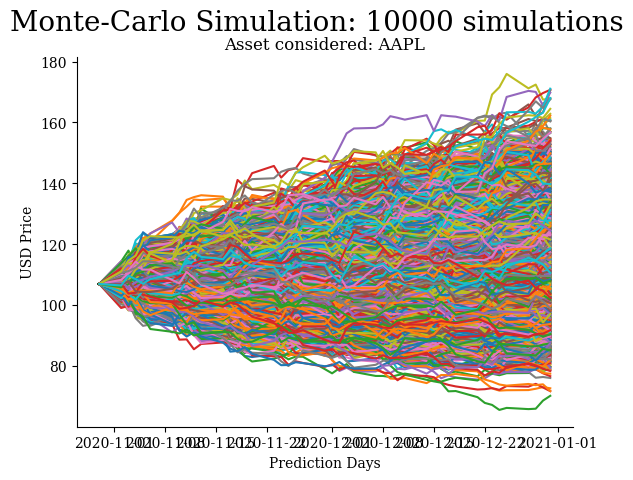

In [9]:
# Plotting the simulations
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Monte-Carlo Simulation: ' + str(scen_size) + ' simulations', fontsize=20)
plt.title('Asset considered: {}'.format(stock_name))
plt.ylabel('USD Price')
plt.xlabel('Prediction Days')
for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=pred_end_date,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
plt.show()

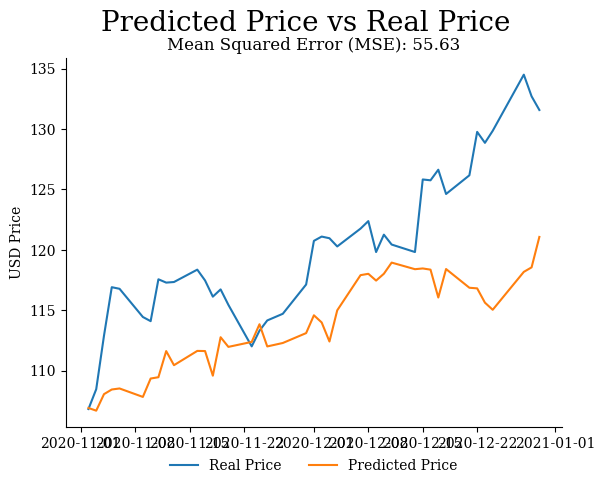

In [10]:
# Plotting the final prediction against the real price
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Predicted Price vs Real Price', fontsize=20)
plt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
plt.ylabel('USD Price')
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.show()

In [ ]:
#high mse => prediction shows bad result
#value should be <20%